### For DECam -
### This notebook estimates the maximum number of electrons per pixel the spaceX satellites would produce on DECam CCDs.
#### We assume a satellite moves at 0.5 deg per sec. Its trail is a Gaussian with FWHM = $\sqrt{1.5^2+1.2^2}$ arcsec, where 1.2 arcsec is the DECam seeing.

In [1]:
import numpy as np
fwhm = 2.4 #np.sqrt(1.5**2+1.2**2) #in arcsec, 4/550e3/np.pi*180*3600 = 1.50 arcsec, DECam PSF FWHM = 1.2 arcsec
angularV = 0.5*60 # in deg/min, 0.5 deg/sec
print('fwhm = %.2f arcsec'%fwhm)

fwhm = 2.40 arcsec


In [2]:
from __future__ import print_function
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed, Bandpass, calcTotalNonSourceNoiseSq, calcM5
import galsim
import matplotlib.pyplot as plt
import os
from lsst.utils import getPackageDir 
import sqlite3

### Full well ranges from 130K to 210K electrons but is typically near 180Ke-.
from http://www.ctio.noao.edu/noao/sites/default/files/DECam/DECamUG_v2.0.5-ARW.pdf

In [3]:
full_well = 180e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 130e3  #some sensors can be as low as 100K e-.

## We first determine what fraction of the flux will be in the center/brightest pixel

In [4]:
#Assume it moves along pixel grid. The time its image center moves from one pixel center to the next is dt
pixel_scale = 0.2637 #arcsec/pixel, from http://www.ctio.noao.edu/noao/content/DECam-What
dt = pixel_scale/(angularV/60*3600) # in seconds

#### Approximate it as a source which appears at one pixel center for dt, then disappears from there, and instantly appears at the next pixel center for dt. During each dt, the source deposit a flux profile that is a Gaussian with FWHM of 1.92 arcsec.
So we are just overlapping Gaussians whose centers are 0.2637 arcsec apart. Considering that the FWHM is much larger than pixel size, the top of the Gaussians are pretty flat. So this should be a pretty good approximation.
This slightly overestimates the flux, because having the Gaussian moving across the pixel in dt would yield a smaller flux for the pixel, compared to when the center of the Gaussian is overlapped with the pixel center during dt.

0.10293347445479589 0.00014649999999999998


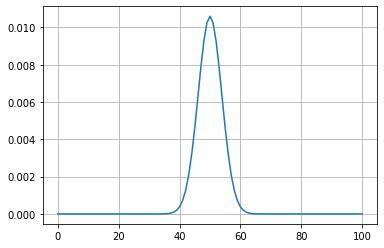

In [5]:
stamp_size = 101
psf = galsim.Gaussian(fwhm=fwhm)
img = galsim.ImageD(stamp_size, stamp_size, scale=pixel_scale)
psf = psf.withFlux(1) #unit flux
psf.drawImage(image=img)
ratio = sum(img.array[50,:])/np.sum(img.array)
plt.plot(img.array[50,:])
print(ratio, dt)
plt.grid()

In [6]:
#what if the trail is 45 deg to the pixel grid?
# dt will be 1.414 time longer, would that give a larger ratio?
print(sum(np.diag(img.array))*1.414)
# it is the same. Bingo. That is it.

0.10291816978594008


### Baseline DECam system, as defined in http://www.ctio.noao.edu/noao/content/decam-filter-information
More specifically, we use http://www.ctio.noao.edu/noao/sites/default/files/DECam/STD_BANDPASSES_DR1.dat

However, according to Zeljko:

Regarding DECam throughput, I talked to Gary Bernstein and Eli Rykoff today. They
say that the throughput normalization is arbitrary on those plots at
http://www.ctio.noao.edu/noao/content/decam-filter-information
(but band-to-band normalization is correct). What they do when they need throughput 
is to re-normalize it so that the mean i band throughput is 1, and then multiply all bands 
by 0.52. This procedure gives the mean DECam g band throughput of about 0.35. 

In [7]:
filterlist = ('g', 'r', 'i', 'z','y')
thru = np.loadtxt('STD_BANDPASSES_DR1.dat')
wavelen = thru[:,0]/10  #convert Angstrom to nanometer
iband1 = np.argmax(thru[:,3]>0.8)
iband2 = len(wavelen) - np.argmax(thru[::-1,3]>0.8)-1
print('i-band wavelen range: ', wavelen[iband1], wavelen[iband2])
scalef = 1./np.mean(thru[iband1:iband2+1,3])*0.52
print('scale factor = %.2f'%scalef)
thru[:,1:-1] = thru[:,1:-1] * scalef

i-band wavelen range:  713.5 853.5
scale factor = 0.58


In [8]:
hardware = {}
system = {}
for i,f in enumerate(filterlist):
    hardware[f] = Bandpass()
    system[f] = Bandpass()
    hardware[f].setBandpass(wavelen, thru[:,i+1]/thru[:,-1]) #first col is wavelength, skip it
    system[f].setBandpass(wavelen, thru[:,i+1])

### Make sure the throughputs match http://www.ctio.noao.edu/noao/content/decam-filter-information

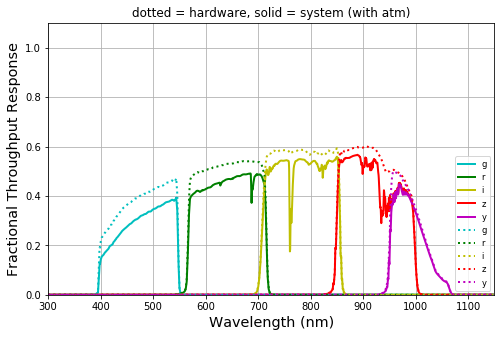

In [9]:
plt.figure(figsize=(8, 5))
st.plotBandpasses(system, newfig=False, addlegend=False)
st.plotBandpasses(hardware, linestyle=':', newfig=False, addlegend=True)
plt.ylim([0, 1.1])
plt.title('dotted = hardware, solid = system (with atm)');

### DECam photometric parameters
For clarify, we ignore Y-band in this notebook, because DES uses exposure times of 90s for griz and 45s for Y band
Ref: DES DR1 paper https://arxiv.org/abs/1801.03181

In [10]:
filterlist = ('g', 'r', 'i', 'z')

In [11]:
# http://www.ctio.noao.edu/noao/content/DECam-What
# http://www.ctio.noao.edu/noao/content/Basic-Optical-Parameters
readnoise=7 
othernoise=0 
darkcurrent=25/3600 # convert ~<25 e-/pixel/hr (spec) to e-/pixel/sec
effarea=10.014*1e4 # = np.pi*((3.934/2*100)**2 - (1.651/2*100)**2) #syseng_throughput uses mm**2
X=1.0

# set exposure to dt
photParams_dt = PhotometricParameters(exptime=dt, nexp=1, platescale=pixel_scale,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)
# typical DES exposure time is 90s. See https://arxiv.org/pdf/1504.02900.pdf
photParams_std = PhotometricParameters(exptime=90, nexp=1, platescale=pixel_scale,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)
#for calculating zero point
photParams_zp = PhotometricParameters(exptime=1, nexp=1, platescale=pixel_scale,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

### Set up the dataframe

In [12]:
properties = ['SatLim']
d = pd.DataFrame(index=filterlist, columns=properties, dtype='float')

### Satellites have solar SED

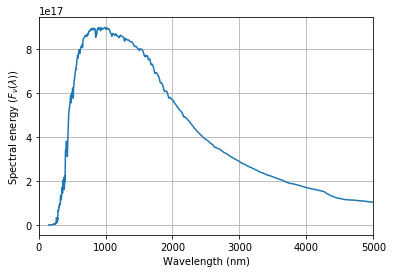

In [13]:
satellite = Sed()
satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
satellite.flambdaTofnu()
plt.plot(satellite.wavelen, satellite.fnu)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Spectral energy ($F_\nu(\lambda)$)')
plt.xlim([0, 5000])
plt.grid()

#### We are interested in twilight (-19 deg sun) and at 50 deg zenith angle.
We use OpSim baseline v1.3 data based found on http://astro-lsst-01.astro.washington.edu:8081/?runId=1
More specifically, http://astro-lsst-01.astro.washington.edu:8081/fbs_db/footprints/baseline_v1.3_10yrs.db

In [14]:
conn = sqlite3.connect('baseline_v1.3_10yrs.db')
df = pd.read_sql('select sunAlt, moonAlt, skyBrightness, altitude, filter from summaryallprops', conn)
conn.close()
#for dealing with the opsim db, see example by Peter Yoachim
# https://github.com/lsst-sims/sims_featureScheduler_runs1.4/blob/master/baseline/Skybrightnesses.ipynb

In [15]:
skyTwilight = {}
print('Depending on where the moon is, sky brightness varies -')
for f in filterlist:
    good = np.where((df['sunAlt'].values > -19.) & (df['filter'] == f) &
                   (df['altitude'].values>35) & (df['altitude'].values<45))  #zenith 50, altitude 40, we take +/-5 deg.
    val = df['skyBrightness'].values[good]
    skyTwilight[f] = np.median(val)
    print('%s: between %.2f and %.2f, median = %.2f'%(f, val.max(), val.min(), skyTwilight[f]))

Depending on where the moon is, sky brightness varies -
g: between 22.08 and 18.93, median = 21.94
r: between 20.98 and 18.36, median = 20.62
i: between 20.15 and 17.36, median = 19.41
z: between 19.11 and 17.34, median = 18.49


In [16]:
def twilightSkyMag2Count(skyMag, f, hardware, photParams):
    '''
    inputs:
        skyMag is the sky magnitude (bright sky has solar SED)
        f is the filter band
        hardware: an bandpass object as defined in the syseng_throughput package
        photParams: an PhotometricParameters object as defined in the syseng_throughput package
    output:
        skycount in each pixel
    '''
    twilightSky = Sed()
    twilightSky.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
    fNorm = twilightSky.calcFluxNorm(skyMag, hardware)
    twilightSky.multiplyFluxNorm(fNorm)
    #print('bright %.2e'%fNorm)
    skyCount = twilightSky.calcADU(hardware, photParams=photParams)* photParams.platescale**2
    return fNorm, skyCount

### Calculate the Skycounts expected in each bandpass.

In [17]:
skyCounts = {}
for f in filterlist:
    fNorm, skyCounts[f] = twilightSkyMag2Count(skyTwilight[f], f, hardware[f], photParams_std)
    print('%s: sky counts (e-/pixel) = %.2f'%(f, skyCounts[f]))

g: sky counts (e-/pixel) = 685.69
r: sky counts (e-/pixel) = 2352.24
i: sky counts (e-/pixel) = 6511.39
z: sky counts (e-/pixel) = 12152.48


In [18]:
#LSST standard dark sky
#skyCounts = {}
#darksky = Sed()
#darksky.readSED_flambda(os.path.join(getPackageDir('syseng_throughputs'),
#                                             'siteProperties', 'darksky.dat'))
#for f in filterlist:
#    skyCounts[f] = darksky.calcADU(hardware[f], photParams=photParams_std)* photParams_std.platescale**2
#    print('%s: sky counts (e-/pixel) = %.2f'%(f, skyCounts[f]))

### Calculate the saturation limits under dark sky: the source should have solar SED

In [19]:
key = 'SatLim'
for f in filterlist:
    satellite = Sed()
    satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
    fNorm = satellite.calcFluxNorm(0, system[f])
    # print('fNorm = %.2e'%fNorm)
    satellite.multiplyFluxNorm(fNorm)
    adu = satellite.calcADU(system[f], photParams=photParams_dt)
    #print(satellite.calcMag(system[f]))
    
    flatsource = Sed()
    flatsource.setFlatSED()
    adu_flat = flatsource.calcADU(system[f], photParams=photParams_dt)
    print('%s, adu = %e, adu_flat = %e, diff = %.2f'%(f, adu, adu_flat, adu-adu_flat))
    #So the ADU is the same as using the flat SED. Does that make sense?
    #yes, according to Lynne. Because the AB magnitude, and the flux, both include the effect of the bandpass (throughput)
    #therefore are specific for each observatory. That is why calcFluxNorm() has system[f] as input.
    #The mapping from mag to flux inside a particular bandpass is unique, and have nothing to do with SED
    
    adu0 = adu*ratio
    #because we assumed a m=0 star
    # we use gain=1.0, so adu = number of e-
    # we also get rid of skycounts from each pixel. This has miminal effect on results
    d[key].loc[f] = np.log10(adu0/(full_well-skyCounts[f]))/2*5

g, adu = 7.470150e+06, adu_flat = 7.470150e+06, diff = -0.00
r, adu = 8.538531e+06, adu_flat = 8.538531e+06, diff = -0.00
i, adu = 8.011991e+06, adu_flat = 8.011991e+06, diff = -0.00
z, adu = 6.240234e+06, adu_flat = 6.240234e+06, diff = -0.00


In [20]:
d

,SatLim
g,1.580677
r,1.735950
i,1.692565
z,1.457106


#### Double-check: do the same calculation using zero points

In [21]:
Zp_t = {}
for f in filterlist:
    Zp_t[f] = system[f].calcZP_t(photParams_zp)
    print('%s: zero point = %.2f'%(f, Zp_t[f]))

g: zero point = 26.77
r: zero point = 26.91
i: zero point = 26.84
z: zero point = 26.57


In [22]:
d_zp = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
key = 'SatLim'
for f in filterlist:
    #number of electrons we can accomodate for the source in dt sec
    ne = (full_well-skyCounts[f])/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/dt
    d_zp[key].loc[f] = (Zp_t[f]-2.5*np.log10(ne))

In [23]:
d_zp

,SatLim
g,1.580677
r,1.735950
i,1.692565
z,1.457106


In [24]:
round(d_zp - d)  #should be idential to above calculations

,SatLim
g,0.0
r,0.0
i,0.0
z,0.0


### Make peak electron counts vs. mag plot

In [25]:
pRatio = ratio
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')

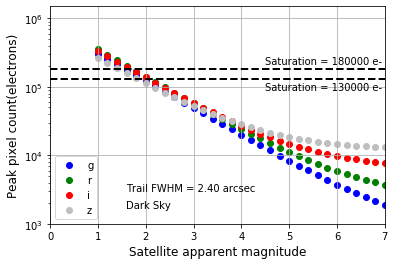

In [26]:
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_dt)
    adu0 = adu*pRatio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = 1 + 0.2 * m
        mags.append(mag)
        npeak = adu0*10**(-mag/2.5)+skyCounts[f]
        npeaks.append(npeak)
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
    d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.plot([0,7.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([0,7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "Trail FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(0,7.0)
plt.ylim(1e3, 1.5e6)
plt.grid()
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);

In [27]:
#check consistency with above calculations.
d_plot.join(d)

,SatLimFromPlot,SatLim
g,1.6,1.580677
r,1.8,1.735950
i,1.8,1.692565
z,1.6,1.457106


In [28]:
decam_ne_mag2 = 180e3 #- skyCounts['r']
decam_ne_mag3 = 10**((2-3)/2.5)*decam_ne_mag2
decam_gain = 4.0
decam_adu_mag3 = decam_ne_mag3/decam_gain

lsst_ne_mag3 = 150e3 #- skyCounts['r']
lsst_gain = 1.5
lsst_adu_mag3 = lsst_ne_mag3/lsst_gain

adu_ratio = lsst_adu_mag3/decam_adu_mag3
effD = np.sqrt(effarea/1e4/np.pi)*2

pred_ratio = (6.423/effD)**2 * (0.2/pixel_scale)**2 * 4.0/1.5
print('calculated adu ratio = %.1f, predicted adu ratio = %.1f'%(adu_ratio, pred_ratio))

calculated adu ratio = 5.6, predicted adu ratio = 5.0


### We can use the zeropoints to do the same calculations and make the same plot

for 5th mag, under dark sky, band g, peak e per pixel = 8375
for 5th mag, under dark sky, band r, peak e per pixel = 11141
for 5th mag, under dark sky, band i, peak e per pixel = 14758
for 5th mag, under dark sky, band z, peak e per pixel = 18576


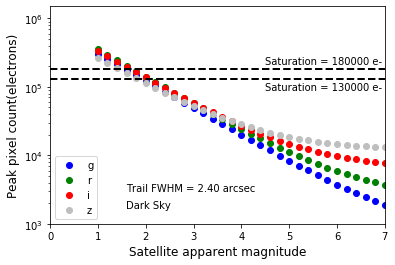

In [29]:
d_plot_zp = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')
fig, ax = plt.subplots()
peak_e_mag_5 = []
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    for m in range(31):
        mag = 1.0 + 0.2 * m
        mags.append(mag)
        #for a source of mag, how many electrons is produced on detector in a second?
        ne = 10**((Zp_t[f] - mag)/2.5)
        # what about dt seconds
        ne *= dt
        # how many fall into the center pixel? on top of the background and others
        npeak = ne*pRatio+ skyCounts[f]
        npeaks.append(npeak)
        d_plot_zp.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
        if mag==5.0:
            peak_e_mag_5.append(npeak)
            print('for 5th mag, under dark sky, band %s, peak e per pixel = %.0f'%(f,npeak))
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
plt.plot([0,7.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([0,7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(4.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "Trail FWHM = %.2f arcsec"%fwhm, color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(0,7.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12)
plt.savefig('Peak_count_by_band_DECam_trail.pdf')

In [30]:
round(d_plot - d_plot_zp) #should be identical to calculations using zero points

,SatLimFromPlot
g,0.0
r,0.0
i,0.0
z,0.0


### what is the surface brightness of the satellite trail? (how much fainter is the trailer compared to when the satellite is stationary on the CCD?)
The instantaneous surface brightness of the satellite is simply the surface brightness if the satellite is stationary relative to our detector.
So here the "surface brightness of the satellite trail" is actually the surface brightness averaged over a period of time. Therefore this surface brightness is dependent on the averaging time. We assume a 90s exposure.

In [31]:
nexp = 1
exptime = 120
fNormTrail = dt/(nexp*exptime)*ratio/photParams_std.platescale**2
dmag = -2.5*np.log10(fNormTrail)
print(dmag)

14.357518121458956


In [32]:
m = 5  #just pick a random mag; won't affect the mag difference below.
for i,f in enumerate(filterlist):
    satellite = Sed()
    satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                         'data', 'kurucz_sun.gz'))
    fNorm = satellite.calcFluxNorm(m, system[f])
    satellite.multiplyFluxNorm(fNorm) #normalize the passband to mag=m
    satellite.multiplyFluxNorm(fNormTrail) #further dilute the light by a factor of fNormTrail
    mTrail = satellite.calcMag(system[f])
    print('%s, %.2f'%(f, mTrail-m))

g, 14.36
r, 14.36
i, 14.36
z, 14.36


### DES DR1 paper gives Single-epoch Magnitude Limit (S/N=10)
https://arxiv.org/abs/1801.03181

* Below we check how well we can reproduce the values in Table 1 of this paper.
* Since the results in Table 1 are measured actuals, we try to bracket those values with darksky and brightsky

In [33]:
def calcM10(skysed, system, hardware, photParams, FWHMeff):
    '''
    This does the calculation for one band
    '''
    
    snr = 10
    
    flatsource = Sed()
    flatsource.setFlatSED()
        
    v_n = calcTotalNonSourceNoiseSq(skysed, hardware, photParams, FWHMeff)

    counts_10sigma = (snr**2)/2.0/photParams.gain + \
                         np.sqrt((snr**4)/4.0/photParams.gain + (snr**2)*v_n)

    # renormalize flatsource so that it has the required counts to be a 10-sigma detection
    # given the specified background
    counts_flat = flatsource.calcADU(system, photParams=photParams)
    flatsource.multiplyFluxNorm(counts_10sigma/counts_flat)

    # Calculate the AB magnitude of this source.
    mag_10sigma = flatsource.calcMag(system)
    return mag_10sigma

In [34]:
FWHM = {'g':1.12, 'r':0.96, 'i':0.88, 'z':0.84, 'y':0.90}
m10DR1 = {'g':23.57, 'r':23.34, 'i':22.78, 'z':22.10, 'y':20.69}
#Tony sent these values from DECam. These are ~50 deg from full moon
skyBrightMag = {'u': 17.7, 'g':19.4, 'r':19.7, 'i':19.4, 'z':18.2, 'y':17.7}
print('     DR1  Our_prediction')
print('          low      high    DR1-low  high-DR1')
for f in filterlist:
    FWHMeff = FWHM[f]*1.21

    darksky = Sed()
    darksky.readSED_flambda(os.path.join(getPackageDir('syseng_throughputs'),
                                             'siteProperties', 'darksky.dat'))
    m10_dark = calcM10(darksky, system[f], hardware[f], photParams_std, FWHMeff)

    brightsky = Sed()
    brightsky.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
    fNorm = brightsky.calcFluxNorm(skyBrightMag[f], hardware[f])
    brightsky.multiplyFluxNorm(fNorm)
    
    m10_bright = calcM10(brightsky, system[f], hardware[f], photParams_std, FWHMeff)
    print('%s: %.2f  %.2f   %.2f     %.2f    %.2f'%(
        f, m10DR1[f], m10_bright, m10_dark, m10DR1[f] - m10_bright,  m10_dark-m10DR1[f]))

     DR1  Our_prediction
          low      high    DR1-low  high-DR1
g: 23.57  22.10   23.47     1.47    -0.10
r: 23.34  22.55   23.26     0.79    -0.08
i: 22.78  22.48   22.91     0.30    0.13
z: 22.10  21.79   22.21     0.31    0.11


### DES performance prediction paper had coadded 5-sigma limiting magnitudes.
 https://arxiv.org/abs/astro-ph/0510346
 * we adjust exposure by a factor of 10 to compare to these predictions

In [35]:
FWHMeff = 0.90
m5Pred = {'g':26.1, 'r':25.6, 'i':25.8, 'z':25.4}
photParams_coadd = PhotometricParameters(exptime=90*10, nexp=1, platescale=pixel_scale,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)
print('   DES05  Our_prediction')
print('          low      high  DES05-low  high-DES05')
for f in filterlist:

    darksky = Sed()
    darksky.readSED_flambda(os.path.join(getPackageDir('syseng_throughputs'),
                                             'siteProperties', 'darksky.dat'))
    m5_dark = calcM5(darksky, system[f], hardware[f], photParams_coadd, FWHMeff)

    brightsky = Sed()
    brightsky.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
    fNorm = brightsky.calcFluxNorm(skyBrightMag[f], hardware[f])
    brightsky.multiplyFluxNorm(fNorm)
    
    m5_bright = calcM5(brightsky, system[f], hardware[f], photParams_coadd, FWHMeff)
    print('%s: %.2f  %.2f   %.2f     %.2f    %.2f'%(
        f, m5Pred[f], m5_bright, m5_dark, m5Pred[f] - m5_bright,  m5_dark-m5Pred[f]))

   DES05  Our_prediction
          low      high  DES05-low  high-DES05
g: 26.10  24.56   25.99     1.54    -0.11
r: 25.60  24.85   25.57     0.75    -0.03
i: 25.80  24.68   25.11     1.12    -0.69
z: 25.40  23.93   24.36     1.47    -1.04
